In [1]:
!pip3 install platypus
!pip3 install ema_workbench platypus-opt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 49 kB 2.5 MB/s 
  Created wheel for platypus: filename=Platypus-1.0-py3-none-any.whl size=12131 sha256=ea068df79340e44ce906b9a4b66ffb67f42cf2aa585c9030f89d30d8c5e5800f
  Stored in directory: /root/.cache/pip/wheels/6c/d7/9b/814f078a14758933a87a5d450635b9646932a685838eff281a
Successfully built platypus
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.6 MB 2.6 MB/s 
     |████████████████████████████████| 70 kB 8.0 MB/s 
  Created wheel for ema-workbench: filename=ema_workbench-2.1.1-py3-none-any.whl size=24633718 sha256=d28518fc3b6da417dc33faaba6b89be5b2b8139fa0ab023535f363896aede274
  Stored in directory: /root/.cache/pip/wheels/f3/d1/d9/98f5cfee98676446eca76b1bb2e696b61be879429ea3beb8d9
Successfully built ema-workbench


In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")
sys.path.append('..')
import datetime as DT
import os
import rbf_functions

In [2]:
rbfs = [rbf_functions.original_rbf,
        rbf_functions.squared_exponential_rbf,
        rbf_functions.inverse_quadratic_rbf,
        rbf_functions.inverse_multiquadric_rbf,
        rbf_functions.exponential_rbf,
        rbf_functions.matern32_rbf,
        rbf_functions.matern52_rbf,
       ]

# Load model output for each activation function

In [3]:
nfearchive = {}
for n in rbfs:
    nfearchive[n.__name__] = {}
for entry in rbfs:
    name = entry.__name__
    output_dir = f"../output_smaller_eps/{name}/"
    for i in os.listdir(output_dir):
        if i.endswith("_hypervolume.csv"):
            archives_by_nfe = pd.read_csv(output_dir + i)
            nfes = archives_by_nfe["Unnamed: 0"].values
            u_nfes = np.unique(nfes)
            selected_nfe = u_nfes[0::5]
            selected_nfe = np.append(selected_nfe, u_nfes[-1::])
            nfearchive[name][int(i.split("_")[0])] = archives_by_nfe.loc[archives_by_nfe['Unnamed: 0'].isin(selected_nfe)]

# Transform the dataframe back into platypus solution instances, to have a collection of solutions for each generation

In [4]:
from platypus import Solution, Problem, GenerationalDistance

n_rbfs = 2
n_objs = 4
n_vars = n_rbfs * 3 

problem = Problem(n_vars, n_objs)

# matters for hypervolume
problem.directions[0] = Problem.MINIMIZE  # MAX_P
problem.directions[1] = Problem.MAXIMIZE  # utility
problem.directions[2] = Problem.MAXIMIZE  # inertia
problem.directions[3] = Problem.MAXIMIZE  # reliability

archives = {}
seeds = np.arange(10, 101, 10).tolist()
for n in rbfs:
    archives[n.__name__] = {}
    for i in seeds:
        archives[n.__name__][i] = {}
for entry in rbfs:
    name = entry.__name__
    for s in nfearchive[name]: #nfearchive[name]:
        for nfe, generation in nfearchive[name][s].groupby("Unnamed: 0"):
            # we slice from 2, getting rid of the first two columns 
            # which contain the NFE and ID of each solution
            archive = []
            for i, row in generation.iloc[:, 2::].iterrows():
                solution = Solution(problem)
                solution.objectives = row
                archive.append(solution)
            archives[name][s][nfe] = archive
        

# Load refsets for each rbf, turn into solutions sets

In [5]:
# load refsets for each rbf
ref_dir = "./refsets/"
ref_sets = {}
for n in rbfs:
    name = n.__name__
    ref_sets[name] = {}
    data = pd.read_csv(f'{ref_dir}{name}_refset.csv')  
    ref_set = []
    for i, row in data.iterrows():
        solution = Solution(problem)
        solution.objectives = row
        ref_set.append(solution)
    ref_sets[name] = ref_set

# Or, load global refset for all rbfs, turn into solution set

In [6]:
# load refset for all rbfs
ref_dir = "./refsets"
ref_sets = {}
data = pd.read_csv(f'{ref_dir}/all_rbf_refset.csv')  
ref_set = []
for i, row in data.iterrows():
    solution = Solution(problem)
    solution.objectives = row
    ref_set.append(solution)

# Calculate generational distance

In [7]:
# gd = GenerationalDistance(reference_set=ref_set)
# nfes = []
# gds = []
# for nfe, archive in archives.items():
#     nfes.append(nfe)
#     gds.append(gd.calculate(archive))
    
tempnfe = {}
tempgd = {}
nfe_sets = {}
gd_sets = {}
for rbf in archives:
    nfe_sets[rbf] = {}
    gd_sets[rbf] = {}
    #gd = GenerationalDistance(reference_set=ref_sets[rbf])
    gd = GenerationalDistance(reference_set=ref_set) #global refset
    print(f"started {rbf} at {DT.datetime.now().strftime('%H:%M:%S')}")
    for seed in archives[rbf]:
        nfe_sets[rbf][seed] = {}
        gd_sets[rbf][seed] = {}
        s_archives = archives[rbf][seed]
        nfes = []
        gds = []
        for nfe, archive in s_archives.items():
            nfes.append(nfe)
            gds.append(gd.calculate(archive))
        nfe_sets[rbf][seed] = nfes
        gd_sets[rbf][seed] = gds
        tempnfe[seed] = nfes
        tempgd[seed] = gds
        dfgd = pd.DataFrame.from_dict(tempgd, orient='index')
        dfnfe = pd.DataFrame.from_dict(tempnfe, orient='index')
        dfgd = dfgd.T
        dfnfe = dfnfe.T
#         dfgd.to_csv(f"gd/gd/{rbf}_gd.csv", index=False)
#         dfnfe.to_csv(f"gd/gd/{rbf}_gd_nfe.csv", index=False)
        dfgd.to_csv(f"./gd/{rbf}_gd_all.csv", index=False) #global refset
        dfnfe.to_csv(f"./gd/{rbf}_gd_nfe_all.csv", index=False) #global refset
        print(f"finished seed: {seed} at {DT.datetime.now().strftime('%H:%M:%S')}")

started original_rbf at 19:54:45
finished seed: 10 at 19:54:45
finished seed: 20 at 19:54:45
finished seed: 30 at 19:54:45
finished seed: 40 at 19:54:45
finished seed: 50 at 19:54:46
finished seed: 60 at 19:54:46
finished seed: 70 at 19:54:46
finished seed: 80 at 19:54:46
finished seed: 90 at 19:54:46
finished seed: 100 at 19:54:46
started squared_exponential_rbf at 19:54:46
finished seed: 10 at 19:54:47
finished seed: 20 at 19:54:47
finished seed: 30 at 19:54:47
finished seed: 40 at 19:54:47
finished seed: 50 at 19:54:47
finished seed: 60 at 19:54:47
finished seed: 70 at 19:54:48
finished seed: 80 at 19:54:48
finished seed: 90 at 19:54:48
finished seed: 100 at 19:54:48
started inverse_quadratic_rbf at 19:54:48
finished seed: 10 at 19:54:48
finished seed: 20 at 19:54:48
finished seed: 30 at 19:54:49
finished seed: 40 at 19:54:49
finished seed: 50 at 19:54:49
finished seed: 60 at 19:54:49
finished seed: 70 at 19:54:49
finished seed: 80 at 19:54:49
finished seed: 90 at 19:54:49
finished 

# Plot results

original_rbf


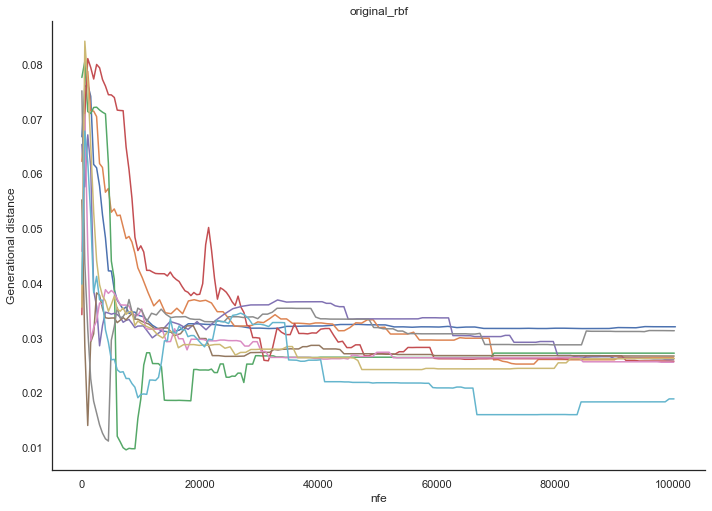

squared_exponential_rbf


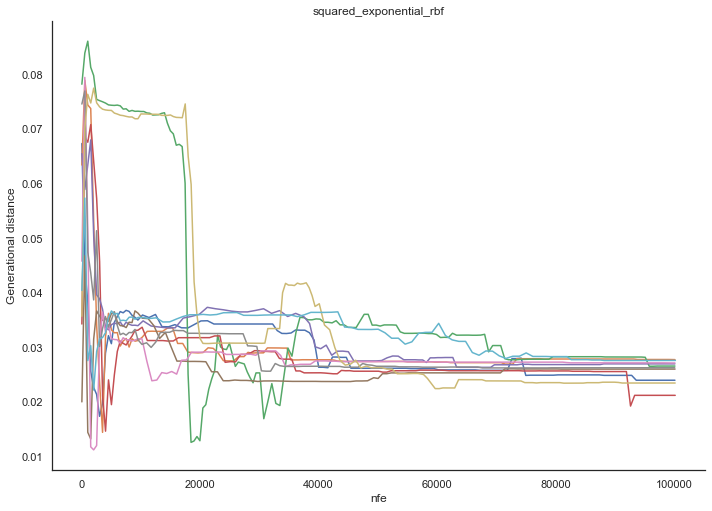

inverse_quadratic_rbf


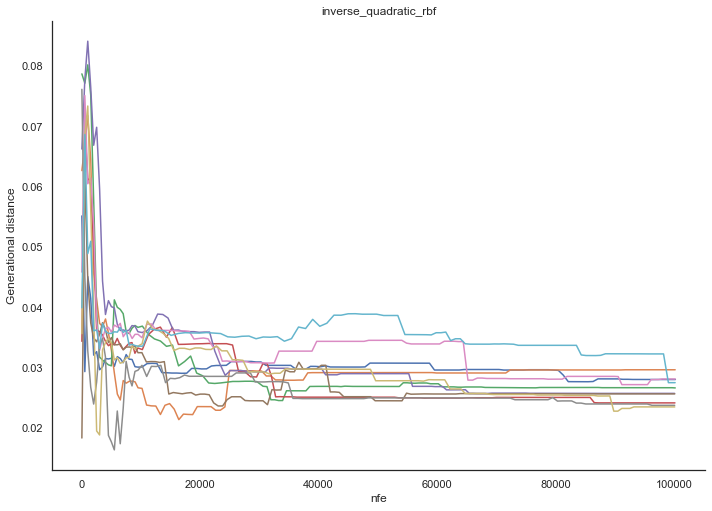

inverse_multiquadric_rbf


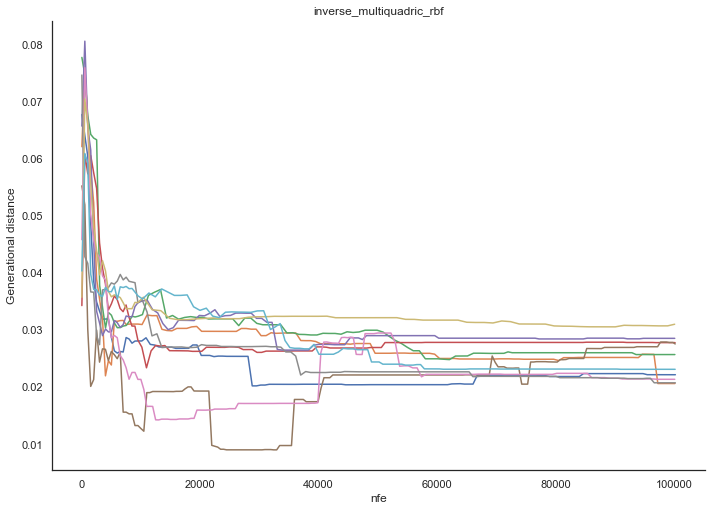

exponential_rbf


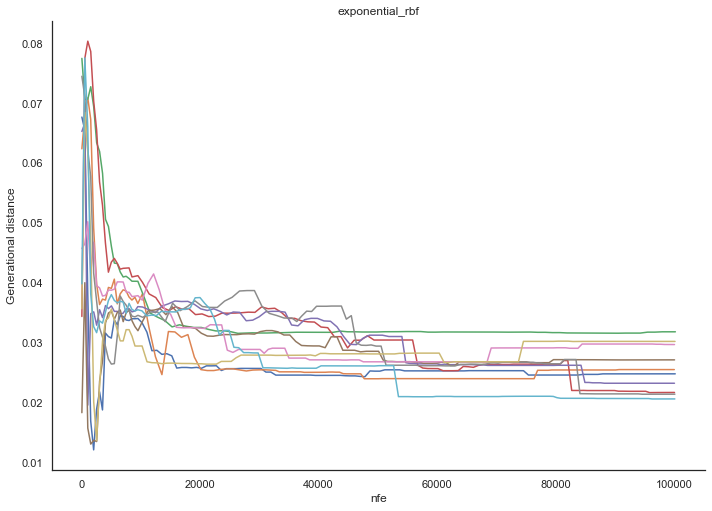

matern32_rbf


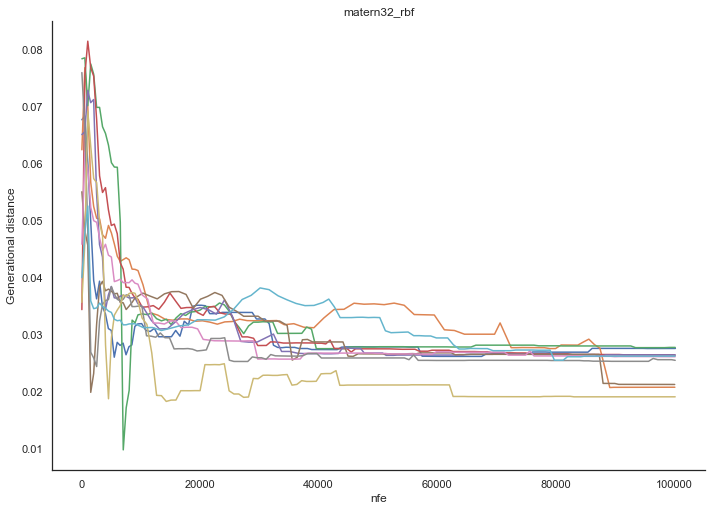

matern52_rbf


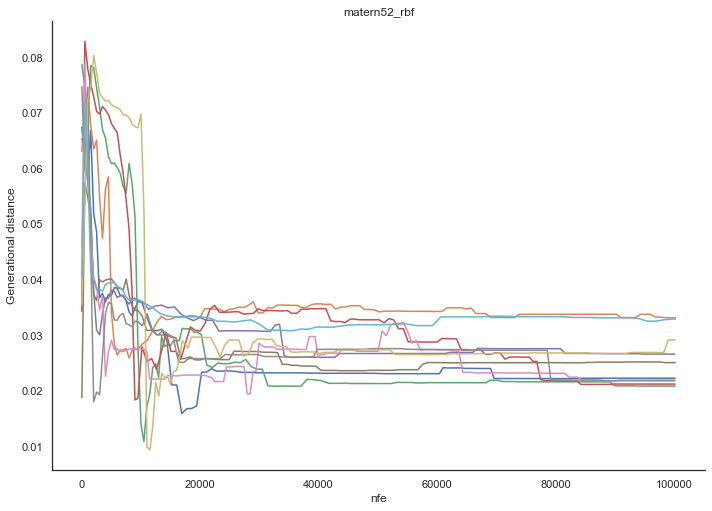

In [22]:
sns.set_style("white")

for entry in rbfs:
    print(entry.__name__)
    name = entry.__name__
    gd = pd.DataFrame.from_dict(gd_sets[name], orient='index').T
    nfe = pd.DataFrame.from_dict(nfe_sets[name], orient='index').T
    
    fig, ax = plt.subplots()
    for i in range(len(nfe.columns)):
        ax.plot(nfe.iloc[:, i], gd.iloc[:, i])
    ax.set_xlabel('nfe')
    ax.set_ylabel('Generational distance')
    ax.set_title(name)
    sns.despine()

    plt.show()

In [11]:
gd

,10,20,30,40,50,60,70,80,90,100
0,0.066771,0.062264,0.077602,0.034287,0.065372,0.055247,0.045853,0.075161,0.035645,0.039862
1,0.075924,0.071944,0.080544,0.071175,0.057622,0.028423,0.070819,0.043726,0.084222,0.067803
2,0.076336,0.078715,0.071370,0.081041,0.067119,0.014052,0.046112,0.031630,0.076543,0.062162
3,0.074162,0.071527,0.071011,0.079412,0.061329,0.029256,0.029560,0.022607,0.065168,0.052362
4,0.061722,0.071457,0.072120,0.077314,0.038662,0.030775,0.031934,0.018499,0.052989,0.038321
...,...,...,...,...,...,...,...,...,...,...
197,NaN,NaN,0.027259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,0.027259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,0.027259,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,NaN,NaN,0.027258,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
nfe

,10,20,30,40,50,60,70,80,90,100
0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0
1,595.0,600.0,598.0,598.0,600.0,599.0,599.0,595.0,598.0,596.0
2,1091.0,1097.0,1094.0,1096.0,1097.0,1092.0,1098.0,1093.0,1096.0,1095.0
3,1590.0,1590.0,1593.0,1595.0,1593.0,1589.0,1593.0,1588.0,1596.0,1593.0
4,2087.0,2088.0,2090.0,2095.0,2091.0,2087.0,2090.0,2085.0,2095.0,2090.0
...,...,...,...,...,...,...,...,...,...,...
197,NaN,NaN,98017.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,NaN,NaN,98515.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199,NaN,NaN,99012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200,NaN,NaN,99624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Local reference set

In [ ]:
# for entry, c in zip(rbfs, sns.color_palette()):
#     rbf = entry.__name__
#     df_gd = pd.read_csv(f"gd/{rbf}_gd.csv")
#     df_gd_nfe = pd.read_csv(f"gd/{rbf}_gd_nfe.csv")
#     fig, ax = plt.subplots(sharex=True)

#     ax.plot(df_gd_nfe, df_gd, color=c)

#     ax.set_xlabel('nfe')
#     ax.set_ylabel('epsilon indicator')
#     ax.set_title(rbf)
#     sns.despine()
#     plt.savefig(f'figs/{rbf}/{rbf}_gd.png')
# plt.show()

# Global reference set

InvalidIndexError: (slice(None, None, None), None)

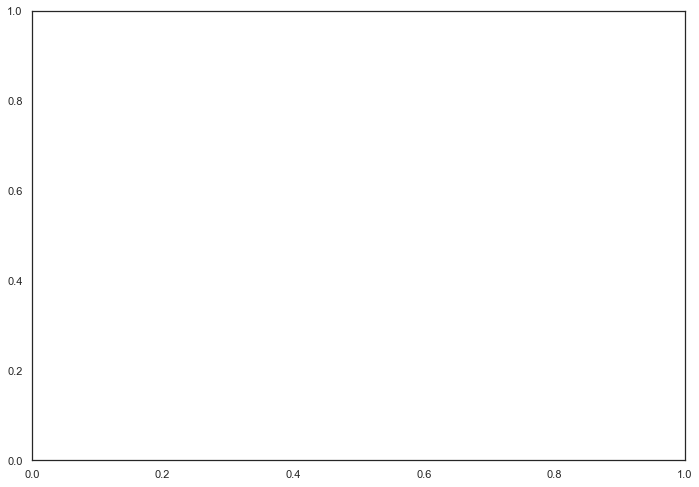

In [10]:
for entry, c in zip(rbfs, sns.color_palette()):
    rbf = entry.__name__
    df_gd = pd.read_csv(f"./gd/{rbf}_gd_all.csv")
    df_gd_nfe = pd.read_csv(f"./gd/{rbf}_gd_nfe_all.csv")
    fig, ax = plt.subplots(sharex=True)

    ax.plot(df_gd_nfe, df_gd, color=c)

    ax.set_xlabel('nfe')
    ax.set_ylabel('Generational Distance')
    ax.set_title(rbf)
    sns.despine()
    plt.savefig(f'../figs/{rbf}/{rbf}_gd_global.png')
    plt.savefig(f'../figs/{rbf}/{rbf}_gd_global.pdf')
plt.show()